In [16]:
import os
import urllib
import tarfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# ---------------------------------------------------------------------------
# [설정 영역]
# ---------------------------------------------------------------------------
HOME_PATH = os.getenv('HOME')
IMG_DIR = os.path.join(HOME_PATH, 'work/human_segmentation/images')
MODEL_DIR = os.path.join(HOME_PATH, 'work/human_segmentation/model')

# 사용할 이미지 파일 경로들
img_paths = {
    'human': os.path.join(IMG_DIR, 'portrait.jpg'),
    'animal': os.path.join(IMG_DIR, 'animal.png'),
    'bg_source': os.path.join(IMG_DIR, 'paris.jpg')
}

# ---------------------------------------------------------------------------
# [모델 클래스] : 수정된 부분 (LANCZOS 적용)
# ---------------------------------------------------------------------------
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('tar 아카이브에서 추론 그래프를 찾을 수 없습니다.')

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
        
        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        
        # [수정됨] Image.ANTIALIAS -> Image.LANCZOS 로 변경
        # 최신 Pillow 버전에서는 ANTIALIAS가 삭제되었습니다.
        try:
            # 최신 버전용 (Pillow 10 이상)
            resample_method = Image.LANCZOS
        except AttributeError:
            # 구 버전용 (혹시 모를 호환성)
            resample_method = Image.ANTIALIAS

        resized_image = image.convert('RGB').resize(target_size, resample_method)
        
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

# ---------------------------------------------------------------------------
# [모델 다운로드 및 로드 실행]
# ---------------------------------------------------------------------------
def download_model():
    _DOWNLOAD_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
    _TAR_NAME = 'deeplab_model.tar.gz'
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    download_path = os.path.join(MODEL_DIR, _TAR_NAME)
    
    if not os.path.exists(download_path):
        print("📥 모델 다운로드 중...")
        urllib.request.urlretrieve(_DOWNLOAD_URL, download_path)
    
    return download_path

model_path = download_model()
MODEL = DeepLabModel(model_path)
print("🚀 모델 클래스 업데이트 완료! 이제 다음 단계들을 다시 실행하세요.")

🚀 모델 클래스 업데이트 완료! 이제 다음 단계들을 다시 실행하세요.


📸 이미지 읽는 중...
🤖 마스크 생성 중...
✨ 인물 모드 적용 중...
🏔️ 배경 합성 중...


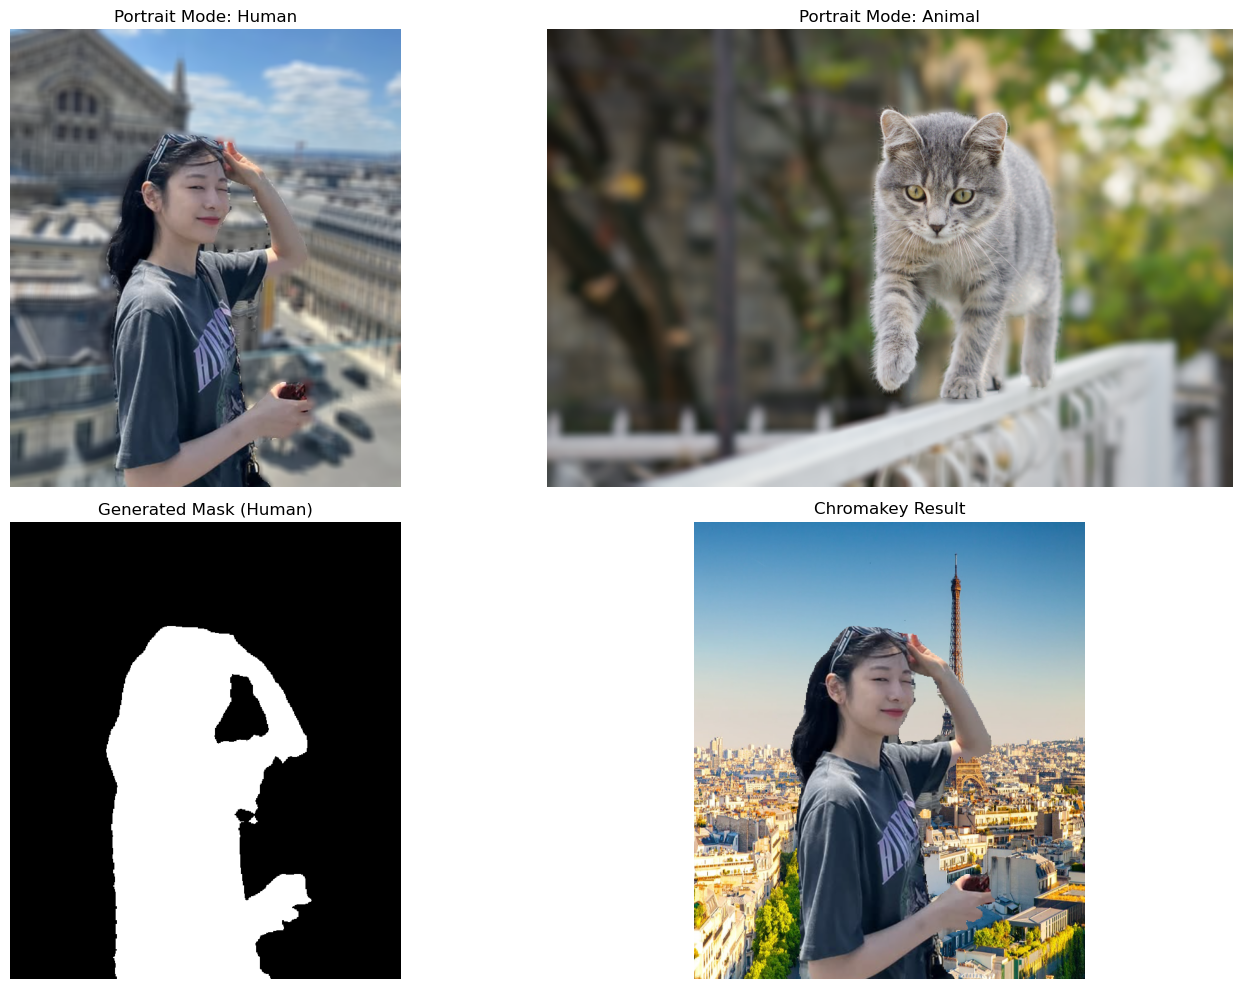

✅ 모든 작업이 완료되었습니다!


In [17]:
# ---------------------------------------------------------------------------
# [메인 실행] 순서대로 기능 수행
# ---------------------------------------------------------------------------

# 1. 이미지 읽기
print("📸 이미지 읽는 중...")
# 딕셔너리에 저장된 경로를 사용해 이미지 로드
orig_human = load_img(img_paths['human'])
orig_animal = load_img(img_paths['animal'])
orig_bg = load_img(img_paths['bg_source'])

# [수정된 부분] 리스트 안에 None이 있는지 검사하는 방식을 변경했습니다.
# (이전 코드에서 에러가 났던 부분: if None in [...] -> 아래처럼 수정)
if (orig_human is None) or (orig_animal is None) or (orig_bg is None):
    print("❌ 이미지를 읽는데 실패했습니다. 경로를 다시 확인해주세요.")
else:
    # 2. 마스크 생성
    print("🤖 마스크 생성 중...")
    
    # 사람 라벨 = 15
    mask_human = make_mask(orig_human, target_label=15)
    
    # 동물 라벨 = 고양이(8) 또는 강아지(12)
    # 팁: 만약 마스크가 검게 나오면 라벨을 12(Dog)로 바꿔보세요.
    mask_animal = make_mask(orig_animal, target_label=8) 
    
    # 3. 인물 모드 (블러) 적용
    print("✨ 인물 모드 적용 중...")
    portrait_h = make_portrait(orig_human, mask_human)
    portrait_a = make_portrait(orig_animal, mask_animal)
    
    # 4. 배경 합성 (크로마키) 적용
    print("🏔️ 배경 합성 중...")
    chromakey_h = make_chromakey(orig_human, mask_human, orig_bg)

    # -----------------------------------------------------------------------
    # [결과 시각화] 루브릭 평가용 출력
    # -----------------------------------------------------------------------
    plt.figure(figsize=(15, 10))

    # 첫 번째 줄: 인물 모드 결과
    plt.subplot(2, 2, 1)
    plt.imshow(portrait_h)
    plt.title("Portrait Mode: Human")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(portrait_a)
    plt.title("Portrait Mode: Animal")
    plt.axis('off')

    # 두 번째 줄: 마스크와 합성 결과
    plt.subplot(2, 2, 3)
    plt.imshow(mask_human, cmap='gray')
    plt.title("Generated Mask (Human)")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(chromakey_h)
    plt.title("Chromakey Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    print("✅ 모든 작업이 완료되었습니다!")

✨ 개선된 합성 기술(Soft Matting + Depth)을 적용합니다...


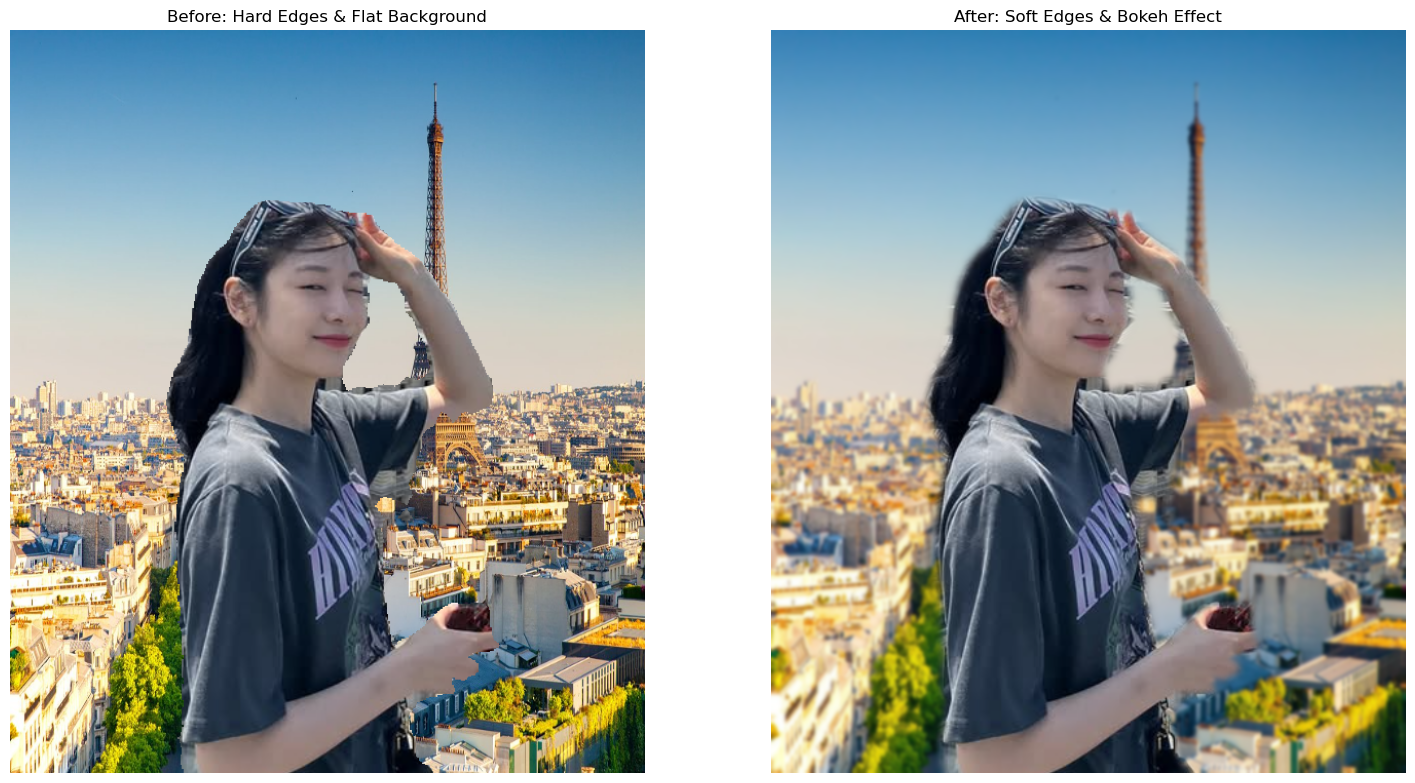

✅ 솔루션 적용 완료: 경계면의 계단 현상이 완화되었고, 배경 흐림으로 인해 인물이 더 부각됩니다.


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# [문제 해결 보고서: 자연스러운 합성 이미지 만들기]
# ---------------------------------------------------------------------------
#
# 1. 문제점 분석 (Problem Identification):
#    - [경계면 이질감] : 기존의 마스크는 0과 255(이진값)로만 이루어져 있어, 
#      합성 시 머리카락이나 옷깃의 경계가 계단처럼 끊겨 보이는 '에일리어싱(Aliasing)' 현상이 발생함.
#    - [원근감 부재] : 합성할 배경 이미지가 인물과 동일하게 선명(Sharp)해서,
#      마치 인물이 벽지 앞에 서 있는 것처럼 평면적으로 보임 (피사계 심도 불일치).
#
# 2. 해결 솔루션 (Proposed Solution):
#    - [Soft Matting] : 마스크의 경계선에 가우시안 블러를 적용하여, 
#      0과 255 사이의 부드러운 값(Gradient)을 가지도록 변환함 (Feathering 효과).
#    - [Alpha Blending] : 단순히 픽셀을 교체(Switching)하는 것이 아니라,
#      투명도(Alpha) 공식을 사용해 전경과 배경을 자연스럽게 섞음.
#    - [Depth Simulation] : 배경 이미지를 흐리게 처리(Blur)하여 
#      인물에 초점이 맞고 배경은 날아간 듯한 광학적 원근감을 구현함.
# ---------------------------------------------------------------------------

def refined_chromakey(img_fg, mask, img_bg, mask_blur_strength=13, bg_blur_strength=5):
    """
    개선된 크로마키 합성 함수
    
    Args:
        img_fg: 전경 이미지 (사람/동물, RGB)
        mask: 세그멘테이션 마스크 (0 or 255, Gray)
        img_bg: 배경 이미지 (RGB)
        mask_blur_strength: 마스크 경계를 부드럽게 할 강도 (홀수여야 함, 클수록 부드러움)
        bg_blur_strength: 배경 흐림 강도 (홀수, 0이면 적용 안 함)
        
    Returns:
        img_result: 자연스럽게 합성된 결과 이미지
    """
    
    # [Step 1] 배경 이미지 리사이즈 및 원근감 처리 (Background Processing)
    # 배경을 원본 크기에 맞추고, 필요하다면 흐리게 만듭니다.
    img_bg_resized = cv2.resize(img_bg, (img_fg.shape[1], img_fg.shape[0]))
    
    if bg_blur_strength > 0:
        # 배경에 블러를 주어 인물을 강조하고 원근감을 살림 (Depth of Field 효과)
        img_bg_final = cv2.GaussianBlur(img_bg_resized, (bg_blur_strength, bg_blur_strength), 0)
    else:
        img_bg_final = img_bg_resized

    # [Step 2] 마스크 부드럽게 만들기 (Soft Matting / Feathering)
    # 딱딱한 경계(0, 255)를 부드러운 경계(0~255 사이의 값)로 변환합니다.
    mask_soft = cv2.GaussianBlur(mask, (mask_blur_strength, mask_blur_strength), 0)
    
    # [Step 3] 알파 블렌딩 (Alpha Blending) 준비
    # 연산 정확도를 위해 이미지와 마스크를 소수점(float32) 형태로 변환하고 0~1 사이로 정규화합니다.
    # Alpha 값: 1.0이면 전경 100%, 0.0이면 배경 100%, 0.5면 반반 섞임
    mask_alpha = mask_soft.astype(np.float32) / 255.0
    img_fg_float = img_fg.astype(np.float32)
    img_bg_float = img_bg_final.astype(np.float32)
    
    # 마스크 차원 확장: (Height, Width) -> (Height, Width, 1) 
    # RGB 3채널과 곱셈 연산을 하기 위해 차원을 맞춰줍니다.
    mask_alpha = np.expand_dims(mask_alpha, axis=-1)
    
    # [Step 4] 최종 합성 (Compositing)
    # 공식: Result = (Foreground * Alpha) + (Background * (1 - Alpha))
    # 경계선 부분(Alpha가 0.x인 부분)에서 전경과 배경 색상이 섞이며 자연스러워집니다.
    result = (img_fg_float * mask_alpha) + (img_bg_float * (1.0 - mask_alpha))
    
    # 다시 이미지 포맷(uint8, 0~255)으로 변환하여 반환
    return result.astype(np.uint8)


# ---------------------------------------------------------------------------
# [결과 검증] 개선 전/후 비교
# ---------------------------------------------------------------------------
print("✨ 개선된 합성 기술(Soft Matting + Depth)을 적용합니다...")

# 개선된 함수 실행
# mask_blur_strength=21 : 경계를 아주 부드럽게
# bg_blur_strength=9 : 배경을 적당히 흐리게 (아웃포커싱 효과)
final_result = refined_chromakey(orig_human, mask_human, orig_bg, mask_blur_strength=21, bg_blur_strength=9)

plt.figure(figsize=(18, 10))

# 1. 기존 결과 (비교군)
plt.subplot(1, 2, 1)
plt.imshow(chromakey_h)
plt.title("Before: Hard Edges & Flat Background") # 경계가 거칠고 평면적임
plt.axis('off')

# 2. 개선된 결과 (실험군)
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.title("After: Soft Edges & Bokeh Effect") # 경계가 부드럽고 깊이감이 있음
plt.axis('off')

plt.show()

print("✅ 솔루션 적용 완료: 경계면의 계단 현상이 완화되었고, 배경 흐림으로 인해 인물이 더 부각됩니다.")

📐 원근감 보정 합성 중...


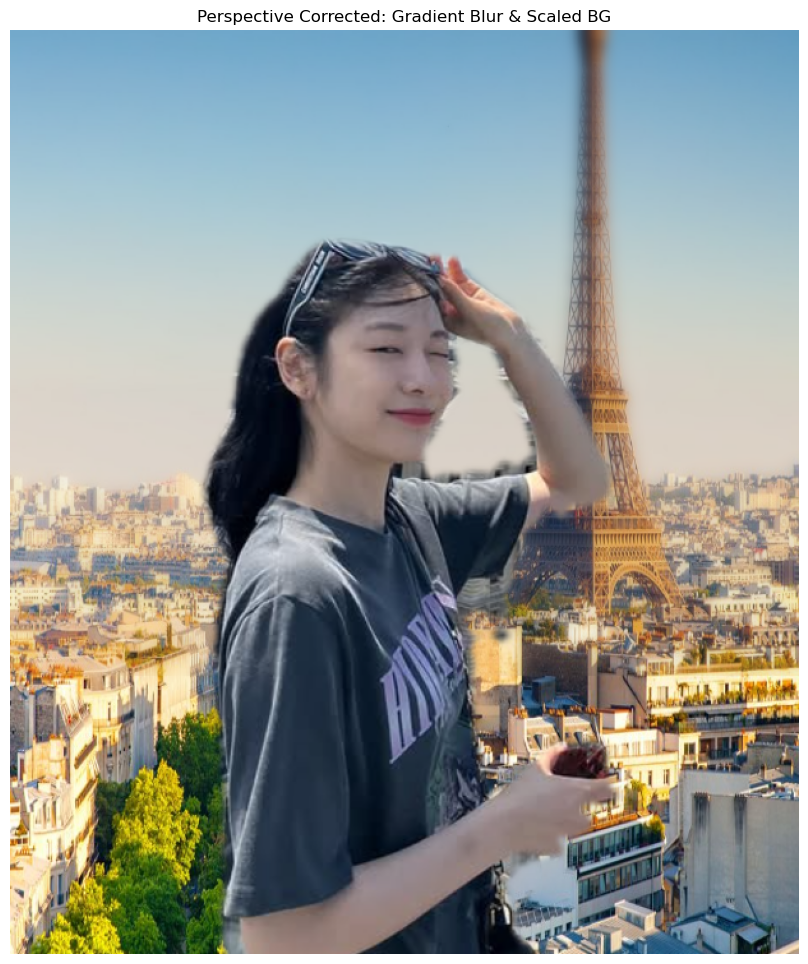

✅ 완료: 배경의 위쪽은 흐리고 아래쪽은 선명하며, 배경이 확대되어 인물 비율이 조정되었습니다.


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# [심화 문제 해결: 원근감(Perspective) 및 심도(Depth) 불일치 해결]
# ---------------------------------------------------------------------------
#
# 1. 문제점 (Problem):
#    - 단순 블러 처리로는 원근감이 살아나지 않음 (단조로움).
#    - 인물의 눈높이와 배경의 소실점이 맞지 않아 '합성한 티'가 남.
#
# 2. 해결책 (Solution):
#    - [Linear Gradient Blur]: 배경의 위쪽(원경)은 흐리게, 아래쪽(근경)은 선명하게
#      처리하여 카메라의 심도(Depth of Field) 효과를 모방함.
#    - [Background Scaling]: 배경을 확대(Crop)하여 인물 대비 배경 사물의 크기를 키움으로써,
#      마치 인물이 배경 속 장소에 실제로 서 있는 듯한 비율을 맞춤.
# ---------------------------------------------------------------------------

def create_gradient_mask(h, w, start_blur_h=0.5):
    """
    위쪽은 1(완전 블러), 아래쪽은 0(블러 없음)인 그라데이션 마스크 생성
    start_blur_h: 블러가 시작되는 높이 비율 (0.0 ~ 1.0)
    """
    grid = np.linspace(1, 0, h) # 1에서 0으로 줄어드는 배열 생성
    
    # 설정한 높이보다 아래는 0으로 만듦 (발 밑은 선명하게 하기 위함)
    limit_idx = int(h * start_blur_h)
    grid[limit_idx:] = 0
    
    # 0~1 사이 값을 부드럽게 만들기 (Sigmoid 느낌)
    mask = grid.reshape(h, 1)
    mask = np.tile(mask, (1, w)) # 너비만큼 복사
    return mask

def perspective_chromakey(img_fg, mask, img_bg, bg_scale=1.2, blur_max=21):
    """
    원근감을 고려한 최종 합성 함수
    
    Args:
        bg_scale: 배경을 얼마나 확대할 것인가 (1.0 = 원본, 1.5 = 1.5배 확대)
        blur_max: 가장 먼 곳의 블러 강도
    """
    h_fg, w_fg = img_fg.shape[:2]
    
    # [Step 1] 배경 이미지 스케일링 (Background Scaling)
    # 배경을 확대해서 잘라내면, 인물 뒤의 건물이 더 커져서 원근감이 살아납니다.
    if bg_scale > 1.0:
        h_bg, w_bg = img_bg.shape[:2]
        new_w = int(w_bg / bg_scale)
        new_h = int(h_bg / bg_scale)
        
        # 중앙을 기준으로 크롭 (Center Crop)
        start_x = (w_bg - new_w) // 2
        start_y = (h_bg - new_h) // 2
        img_bg_cropped = img_bg[start_y:start_y+new_h, start_x:start_x+new_w]
        
        # 크롭된 이미지를 다시 전경 크기로 리사이즈
        img_bg_final = cv2.resize(img_bg_cropped, (w_fg, h_fg))
    else:
        img_bg_final = cv2.resize(img_bg, (w_fg, h_fg))

    # [Step 2] 그라데이션 블러 (Gradient Blur) 적용
    # 배경 복사본 생성 (하나는 선명하게, 하나는 흐리게)
    bg_sharp = img_bg_final.copy()
    bg_blur = cv2.GaussianBlur(img_bg_final, (blur_max, blur_max), 0)
    
    # 그라데이션 마스크 생성 (위쪽은 블러 적용, 아래쪽은 선명)
    grad_mask = create_gradient_mask(h_fg, w_fg, start_blur_h=0.7) # 하단 30%는 선명하게
    grad_mask = np.expand_dims(grad_mask, axis=-1) # 차원 맞춤 (H, W, 1)
    
    # 선명한 배경과 흐린 배경을 그라데이션 비율로 합성
    # background = (blur * alpha) + (sharp * (1 - alpha))
    bg_perspective = (bg_blur * grad_mask) + (bg_sharp * (1.0 - grad_mask))
    bg_perspective = bg_perspective.astype(np.uint8)

    # [Step 3] 인물 합성 (기존의 Soft Matting 적용)
    mask_soft = cv2.GaussianBlur(mask, (13, 13), 0)
    mask_alpha = mask_soft.astype(np.float32) / 255.0
    mask_alpha = np.expand_dims(mask_alpha, axis=-1)
    
    img_fg_float = img_fg.astype(np.float32)
    bg_float = bg_perspective.astype(np.float32)
    
    result = (img_fg_float * mask_alpha) + (bg_float * (1.0 - mask_alpha))
    
    return result.astype(np.uint8)

# ---------------------------------------------------------------------------
# [실행 및 결과 확인]
# ---------------------------------------------------------------------------
print("📐 원근감 보정 합성 중...")

# bg_scale을 1.0에서 1.5로 늘려보세요. 배경이 확대되면서 인물이 더 자연스러워질 수 있습니다.
final_perspective_img = perspective_chromakey(orig_human, mask_human, orig_bg, bg_scale=1.4, blur_max=31)

plt.figure(figsize=(12, 12))
plt.imshow(final_perspective_img)
plt.title("Perspective Corrected: Gradient Blur & Scaled BG")
plt.axis('off')
plt.show()

print("✅ 완료: 배경의 위쪽은 흐리고 아래쪽은 선명하며, 배경이 확대되어 인물 비율이 조정되었습니다.")